# Лабораторная работа №3. Реализация сверточной нейронной сети

### Данные: В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

Ниже будут прописаны все библиотеки, которые мы используем в лабораторной работе

In [3]:
import pathlib
import requests
import tarfile
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

### ЭТАП 1. Подготовительный

#### Здесь мы загрузим данные, избавимся от дупликатов и перемешаем данные. Код взят из лабораторной работы 1

#### Загрузим данные

In [4]:
url = "https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz"
download_dir = "notMNIST_dataset_big"


if not os.path.exists(download_dir):
    os.makedirs(download_dir)

response = requests.get(url)
with open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "wb") as f:
    f.write(response.content)

with tarfile.open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "r:gz") as tar:
    tar.extractall(download_dir)

print("Данные успешно загружены и извлечены.")

Данные успешно загружены и извлечены.


In [5]:
data_dir = os.path.join(download_dir, "notMNIST_large")
data_dir = pathlib.Path(data_dir)
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

#### Перед тем как делить данные на выборки, "перемешаем" между собой картинки из разных папок собой, чтобы не получилось так, что в одной выборке все буквы одного из классов, а в другой выборке букв этого класса вообще нет


In [6]:
image_paths = list(data_dir.glob("*/*.png"))
image_paths.sort()
random.shuffle(image_paths)

#### Избавимся от дупликатов изображений

Для начала напишем функцию для вычисления дифференциального хеша (dHash) изображения, чтобы было проще убрать дупликаты

In [7]:
def dhash(image, hash_size=8):
    # Изменяем размер изображения до размера hash_size + 1 на hash_size  и преобразуем его в оттенки серого
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    hash_string = ""
    
    # Сравниваем пиксели по строкам
    for i in range(hash_size):
        for j in range(hash_size):
            if gray[i, j] > gray[i, j + 1]:
                hash_string += "1"
            else:
                hash_string += "0"

    return hash_string

Создадим словарь, где ключами будут все возможные различные кэши изображений, а значениями будут списки путей к картинкам, у которых конкретный кэш

In [8]:
image_hashes = {}
for image_path in image_paths:
    image = cv2.imread(str(image_path))
    if image is not None:
        if image.shape[0] != 0 and image.shape[1] != 0:
            hashed_image = dhash(image)

            different_hashes = image_hashes.get(hashed_image, [])
            different_hashes.append(image_path)
            
            image_hashes[hashed_image] = different_hashes

А уже следующей функцией удалим все дупликаты изображений и оставим только первые картинки из повторяющихся

In [9]:
images_whithout_duplicates = []
hash_len = 0

for (different_hashes, hashes_paths) in image_hashes.items():
    images_whithout_duplicates.append(hashes_paths[0])
    hash_len += len(hashes_paths)
    
print(f"Было удалено {hash_len - len(images_whithout_duplicates)} дупликатов")

Было удалено 176474 дупликатов


####  Разделим выборку

In [10]:
data = []
labels = []
for file in images_whithout_duplicates:
    image = cv2.imread(str(file))
    
    # Достаём в какой папке (и к какому классу соответственно, относится изображение)
    label = str(file.parent).split('\\')[-1]
    
    # с помощью reshape преобразуем изображение в одномерный массив и нормализуем каждый из 
    # полученных веторов с помощью деления его на 255. Таким образом все числа в массиве от 0 до 1
    # data.append(image.reshape(-1)/255)
    
    data.append(image/255)
    
    # Добавляем в список labels индекс буквы (0-A, 1-B, 2-C,...)
    labels.append(classes.index(label))

In [11]:
print(len(data))

352640


In [12]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data[:220000], np.float32), np.array(labels[:220000], np.float32),
                                                    test_size=20000/220000, random_state=42)

In [13]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))


200000
20000
200000
20000


### ЭТОП 2. Основной

 #### Здесь будет выполнение лабораторной работы 3

#### 1. Реализуем нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации

In [14]:
conv_model = keras.Sequential([

    # Первый свёрточный слой с 32 фильтрами (значит столько признаков будут выделять)
    # и окно размера 3 на 3 пикселя будет переходить
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),

    # Второй свёрточный слой
    keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # Слой Flatten, который преобразует многомерные данные в одномерный вектор перед подачей их на полносвязный слой
    keras.layers.Flatten(),

    # Добавляем полносвязный слой с 64 нейронами 
    keras.layers.Dense(64, activation='relu'),

    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

#### "Скомпилируем" нашу модель нейронной сети

In [15]:
conv_model.compile(optimizer=keras.optimizers.SGD(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Обучим нашу модель нейронной сети

In [18]:
history_conv_model = conv_model.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
5625/5625 [==============================] - 174s 31ms/step - loss: 0.3162 - accuracy: 0.9038 - val_loss: 0.3951 - val_accuracy: 0.8831
Epoch 2/50
5625/5625 [==============================] - 166s 30ms/step - loss: 0.2932 - accuracy: 0.9104 - val_loss: 0.3887 - val_accuracy: 0.8870
Epoch 3/50
5625/5625 [==============================] - 171s 30ms/step - loss: 0.2720 - accuracy: 0.9159 - val_loss: 0.3934 - val_accuracy: 0.8880
Epoch 4/50
5625/5625 [==============================] - 168s 30ms/step - loss: 0.2514 - accuracy: 0.9224 - val_loss: 0.3939 - val_accuracy: 0.8909
Epoch 5/50
5625/5625 [==============================] - 169s 30ms/step - loss: 0.2310 - accuracy: 0.9278 - val_loss: 0.4064 - val_accuracy: 0.8902
Epoch 6/50
5625/5625 [==============================] - 168s 30ms/step - loss: 0.2108 - accuracy: 0.9346 - val_loss: 0.4205 - val_accuracy: 0.8907
Epoch 7/50
5625/5625 [==============================] - 170s 30ms/step - loss: 0.1907 - accuracy: 0.9403 - val_loss: 0

#### Вычислим точность работы на тестовых данных нашей нейронной сети

In [19]:
_, test_acc = conv_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of model_relu_act:', test_acc)

Test accuracy of model_relu_act: 0.8891000151634216


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


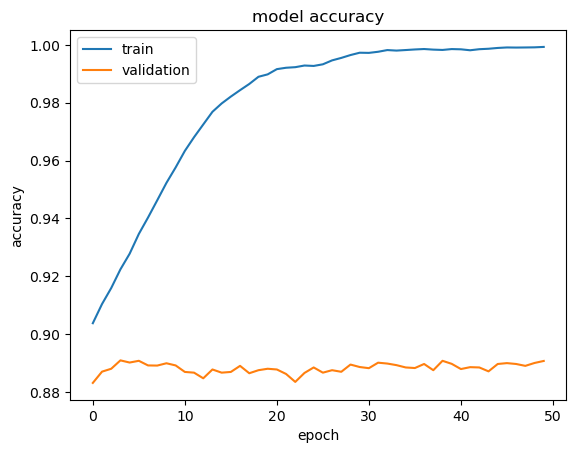

In [20]:
print(history_conv_model.history.keys())
# summarize history for accuracy
plt.plot(history_conv_model.history['accuracy'])
plt.plot(history_conv_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

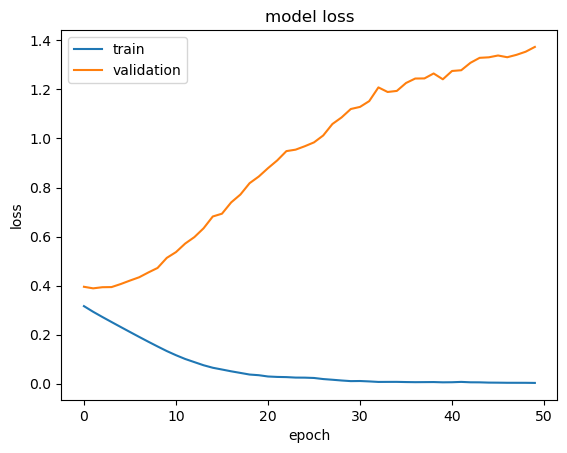

In [21]:
plt.plot(history_conv_model.history['loss'])
plt.plot(history_conv_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Точность у полученной нейронной сети 0.889
# НО ПРИ ЭТОМ ОНА ПЕРЕОБУЧЕНА
### Для борьбы с переобучением можно использовать регуляризацию L2 и случайное "отключение" части нейронов в слоях на каждом этапе обучения (Dropout).


### 2. Заменим сверточные слои на слои, реализующие операцию пулинга (Pooling) с функцией максимума 

In [22]:
pooling_model = keras.Sequential([
    
    # Первый слой операции пулинга с функцией максимума и окном размера (2, 2). 
    # Он уменьшает размерность входных данных, сохраняя при этом наибольшие значения из каждого окна.
    keras.layers.MaxPooling2D(pool_size=(2, 2), input_shape=(28, 28, 3)),
    
    # Второй слой операции пулинга с функцией максимума
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Слой Flatten, который преобразует многомерные данные в одномерный вектор перед подачей их на полносвязный слой
    keras.layers.Flatten(),
    
    # Добавляем полносвязный слой со 128 нейронами 
    keras.layers.Dense(units=128, activation='relu'),
    
    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [23]:
pooling_model.compile(optimizer=keras.optimizers.SGD(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history_pooling_model = pooling_model.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
5625/5625 [==============================] - 16s 3ms/step - loss: 0.9494 - accuracy: 0.7322 - val_loss: 0.8268 - val_accuracy: 0.7635
Epoch 2/50
5625/5625 [==============================] - 14s 3ms/step - loss: 0.7990 - accuracy: 0.7649 - val_loss: 0.7783 - val_accuracy: 0.7707
Epoch 3/50
5625/5625 [==============================] - 15s 3ms/step - loss: 0.7595 - accuracy: 0.7722 - val_loss: 0.7523 - val_accuracy: 0.7770
Epoch 4/50
5625/5625 [==============================] - 14s 3ms/step - loss: 0.7346 - accuracy: 0.7783 - val_loss: 0.7313 - val_accuracy: 0.7805
Epoch 5/50
5625/5625 [==============================] - 14s 2ms/step - loss: 0.7164 - accuracy: 0.7836 - val_loss: 0.7234 - val_accuracy: 0.7829
Epoch 6/50
5625/5625 [==============================] - 14s 3ms/step - loss: 0.7018 - accuracy: 0.7878 - val_loss: 0.7073 - val_accuracy: 0.7886
Epoch 7/50
5625/5625 [==============================] - 15s 3ms/step - loss: 0.6892 - accuracy: 0.7912 - val_loss: 0.6955 - val_ac

In [25]:
_, test_acc = pooling_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of regulized_model_relu_act:', test_acc)

Test accuracy of regulized_model_relu_act: 0.8185499906539917


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


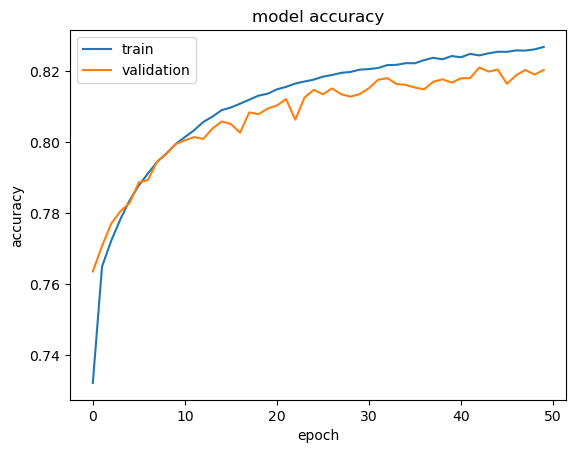

In [26]:
print(history_pooling_model.history.keys())
# summarize history for accuracy
plt.plot(history_pooling_model.history['accuracy'])
plt.plot(history_pooling_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

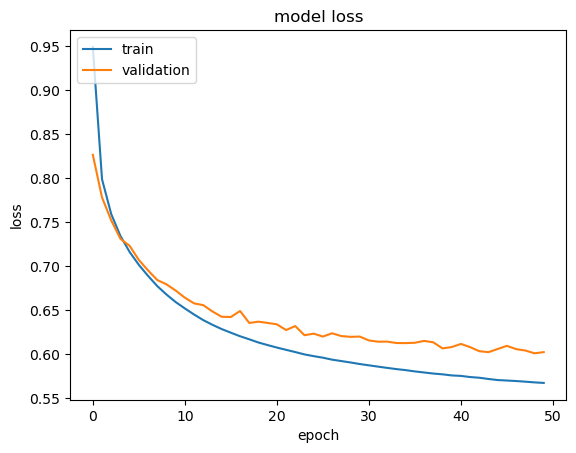

In [27]:
plt.plot(history_pooling_model.history['loss'])
plt.plot(history_pooling_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Точность данной модели на тестовой выборке составила: 81,8%.

Точность данной модели по сравнению с предыдущей намного меньше, так как модель, состоящая только из pooling-слоёв не способна извлекать признаки из изображения и обрабатывать их, а только уменьшать размерность данных.

### 3. Реализуем классическую архитектуру сверточных сетей LeNet-5.
В общем она состоит из "семи" слоёв (не считая входного). Ипользует пулинг слой с функцией среднего

In [28]:
lenet_5_model = keras.Sequential([
    
    # Первый свёрточный слой с 6 фильтрами (значит столько признаков будут выделять) 
    # и окно размера 5 на 5 пикселей будет переходить
    keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 3)),
    
    # Первый слой пулинга с функцией среднего
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    
    # Второй свёрточный слой с 16 фильтрами
    keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    
    # Второй слой пулинга с функцией среднего
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    
    # Слой Flatten, который преобразует многомерные данные в одномерный вектор перед подачей их на полносвязный слой
    keras.layers.Flatten(),
    
    # Первый полносвязный слой со 120 нейронами 
    keras.layers.Dense(units=120, activation='relu'),
    
    # Второй полносвязный слой с 84 нейронами 
    keras.layers.Dense(units=84, activation='relu'),
    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


In [29]:
lenet_5_model.compile(optimizer=keras.optimizers.SGD(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
history_lenet_5_model = lenet_5_model.fit(x_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
5625/5625 [==============================] - 43s 8ms/step - loss: 0.7815 - accuracy: 0.7661 - val_loss: 0.5938 - val_accuracy: 0.8226
Epoch 2/50
5625/5625 [==============================] - 43s 8ms/step - loss: 0.5478 - accuracy: 0.8350 - val_loss: 0.5211 - val_accuracy: 0.8417
Epoch 3/50
5625/5625 [==============================] - 42s 8ms/step - loss: 0.4901 - accuracy: 0.8508 - val_loss: 0.4851 - val_accuracy: 0.8511
Epoch 4/50
5625/5625 [==============================] - 43s 8ms/step - loss: 0.4568 - accuracy: 0.8612 - val_loss: 0.4542 - val_accuracy: 0.8601
Epoch 5/50
5625/5625 [==============================] - 42s 7ms/step - loss: 0.4320 - accuracy: 0.8677 - val_loss: 0.4349 - val_accuracy: 0.8681
Epoch 6/50
5625/5625 [==============================] - 42s 7ms/step - loss: 0.4131 - accuracy: 0.8733 - val_loss: 0.4277 - val_accuracy: 0.8675
Epoch 7/50
5625/5625 [==============================] - 43s 8ms/step - loss: 0.3979 - accuracy: 0.8773 - val_loss: 0.4080 - val_ac

In [31]:
_, test_acc = lenet_5_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of regulized_model_sigmoid_act:', test_acc)

Test accuracy of regulized_model_sigmoid_act: 0.8909500241279602


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


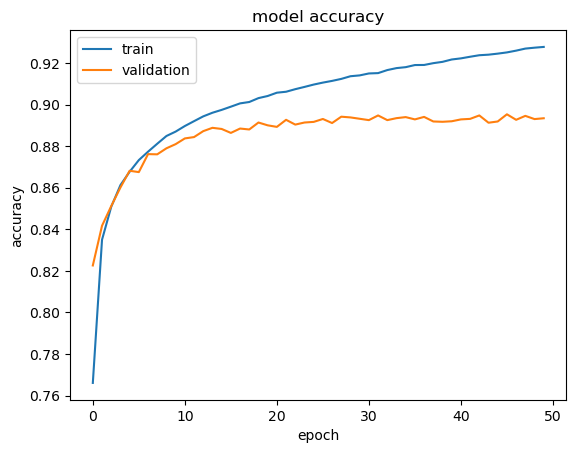

In [32]:
print(history_lenet_5_model.history.keys())
# summarize history for accuracy
plt.plot(history_lenet_5_model.history['accuracy'])
plt.plot(history_lenet_5_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

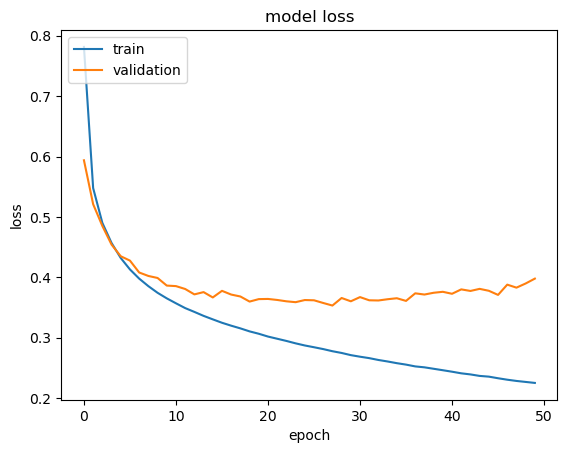

In [33]:
plt.plot(history_lenet_5_model.history['loss'])
plt.plot(history_lenet_5_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Точность данной модели на тестовой выборке составила:89,1%.

LeNet-5 использует серию сверточных слоев и слоев объединения для извлечения соответствующих признаков из входных изображений, что делает его эффективной архитектурой для классификации изображений.

# ИТОГО

### Логистическая модель (Лабораторная работа 1): 
Точность модели составила 79,1 %

### Полносвязная нейронная сеть (Лабораторная работа 2): 
Точность модели составила 88,4 %

### Полносвязная нейронная сеть с регуляризацией и методом сброса нейронов (Лабораторная работа 2): 
Точность модели - 89,2%.

### Полносвязная нейронная сеть с динамически изменяемой скоростью обучения (Лабораторная работа 2):
Точность модели - 89,3%.

### Нейронная сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации (Лабораторная работа 3):
Точность модели - 88,9%.

### Нейронная сеть с двумя слоями, реализующими операцию пулинга, и одним полносвязным с нейронами с кусочно-линейной функцией активации (Лабораторная работа 3):
Точность модели - 81,8%.

### Свёрточная нейронная сеть архитектуры LeNet-5  (Лабораторная работа 3):
Точность модели - 89,1%.

# Сравнение моделей в данной лабораторной:

CNN с двумя сверточными слоями и одним полносвязным. Эта архитектура представляет собой простую CNN с двумя сверточными слоями, за которыми следует полносвязный слой для классификации. Это базовая архитектура, которую можно использовать для простых задач классификации изображений, но она может неэффективно работать с более сложными задачами или большими наборами данных.

CNN со слоями пулинга. Замена сверточных слоев слоями пула может привести к более простой архитектуре, которую можно будет быстрее обучать, но это также может привести к снижению точности. Эта архитектура может подойти для простых задач классификации изображений или при наличии ограничений памяти.

LeNet-5: Архитектура LeNet-5 включает в себя как сверточные уровни, так и уровни пула, по несколько уровней каждого. Она также включает в себя два полностью связанных слоя и выходной слой с функцией активации softmax. LeNet-5 хорошо справляется с простыми задачами классификации изображений, такими как распознавание рукописных цифр, но может быть не столь эффективен для более сложных задач или больших наборов данных.

# Выводы

Хоть сверточные нейронные сети демонстрируют примерно такую же точность, как и полносвязные нейронные сети (но большую точность по сравнению с логистической моделью), но также они демонтрируют намного ниже значения функции потерь по сравнению с альтернативными моделями.

В сравнении с логистической регрессией, нейронные сети обладают ключевым преимуществом в способности извлекать высокоуровневые признаки из данных и моделировать сложные нелинейные зависимости. Однако логистическая регрессия остается предпочтительной в случае простых данных с линейными зависимостями, благодаря своей простоте и легкости в интерпретации.

При сравнении свёрточных нейронных сетей с полносвязными нейронными сетями выявляются ряд особенностей, делающих свёрточные сети более эффективными:

1. Автоматическое извлечение иерархии признаков из изображений: Свёрточные нейронные сети способны обнаруживать простые характеристики, такие как края и текстуры, а затем использовать их для выявления более сложных признаков, например, объектов.
2. Меньшее количество параметров: Сверточные сети имеют меньше параметров, чем полносвязные, что делает их эффективнее при обучении на больших объемах данных. Использование общих весов для свертки позволяет лучше обобщать изображения.
3. Использование pooling-слоев: Это позволяет уменьшить размерность данных, сохраняя важные признаки и предотвращая переобучение и воздействие шума.


Свёрточные нейронные сети обычно обеспечивают более высокую точность при работе с изображениями, а также с аудио- и видеоданными, чем полносвязные сети.

### В целом, выбор архитектуры будет зависеть от конкретных требований задачи классификации изображений, включая сложность задачи, размер набора данных и доступные вычислительные ресурсы. Возможно, придется поэкспериментировать с несколькими архитектурами и гиперпараметрами, чтобы определить лучший подход.